# Human Action Correctness Gregg_0.1 

## CNN using 2D conv layers (batch, H, W, channels)

In [120]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from tensorflow.python.framework import ops
import utils as u
import importlib
importlib.reload(u)

<module 'utils' from 'C:\\Users\\ghait\\Desktop\\MSc\\CS5500\\implementation\\Final\\utils.py'>

## Read and interpolate the data in the shape [400x179x66]  [sample,frames, joints coordinates] 

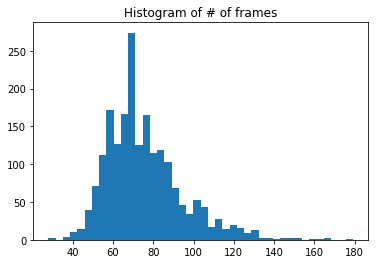

Min:  28 , Max: 179


In [121]:
# get the highest number of frames that a sequence has 
path = 'C:/Users/ghait/Desktop/MSc/CS5500/Dataset/Kinect/*/*.txt'
max_frm, min_frm = u.frame_max_min(path,"hist")
print("Min: ", min_frm, ", Max:",max_frm)

## Dwonsample and Upsample

In [122]:
"""
Read the files and downsample or upsample to get equal size. 
Parameters:
path -- locaiton of the dataset
inter_method -- to choose the appropriate interpolation methods (upsampling):
                The DEFAULT is POLYNOMIAL, and the others:
                ‘linear’: Ignore the index and treat the values as equally spaced. 
                ‘time’: Works on daily and higher resolution data to interpolate given length of interval.
                ‘index’, ‘values’: use the actual numerical values of the index.
                ‘pad’: Fill in NaNs using existing values forwards.
                ‘back_fill’ Fill in NaNs using existing values backwards.
                ‘mean’ Fill in NaNs with mean value of predecessor and successor coordinate 
                ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘spline’, ‘barycentric’, ‘polynomial’: these functions are 
                passed to scipy.interpolate.interp1d. These methods use the numerical values of the index.
                Both ‘polynomial’ and ‘spline’ require that you also specify an order (int), and it is 3 (cubic polynomial) (will explain why) 
sampling_method -- to choose either upsampling or downsampling. The DEFAULT is DOWNSAMPLING
"""
# upsampling / downsampling movements:
_X, _Y = u.read_files(path, inter_method="zero", sampling_method= "upsampling") # and Tqdam 


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [20:18<00:00,  1.66it/s]


### Read the files according to threshold 

In [76]:
# Threshold approach
_X, _Y = u.read_files_threshold(path)

threshold:  [1.5376512028839273, 0.8725795904103362, 1.7296980273728368, 1.2286645396534837, 0.9544282889345874, 0.6832300905829993, 1.4480363554987576, 1.1307212789841568, 0.9541707242652826, 0.7332039982984807, 1.7307301186050685, 0.9790055177934811, 1.8345124061144742, 1.5244068690652626, 1.3419981846500197, 0.9504557075922091, 1.107993042796866, 0.9423634376575284, 0.7815489904094671, 0.8142873843301711]


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:16<00:00, 13.62it/s]


### Read the files and according to the lowest number of frames

In [4]:
# read according to the lowest number of frames 
_X, _Y = u.read_files_lowest(path)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 645.97it/s]


In [123]:
# Store _X and _Y to be used in different notebooks
%store _X
%store _Y

Stored '_X' (ndarray)
Stored '_Y' (ndarray)


## 4D tensor

In [131]:
# Add one more dimension to create a tensor that will be fed to CNN
num_joint = _X.shape[2] 
num_frm = _X.shape[1]
num_file = _X.shape[0]

temp = np.zeros((num_file,1,num_frm,num_joint))
for h in range(num_file):
    temp[h][0][:][:] = _X[h,:,:]

X_4d = temp 

# Reshape it to have 4 D shape such as (m, H, W, C) where C is number of channel
X_4d = np.rollaxis(np.rollaxis(X_4d, 2, 1),3,2) 
print(X_4d.shape)
print(_Y.shape)

(2000, 179, 66, 1)
(2000, 3)


## Normalisation

In [132]:
X_min = X_4d.min(axis=(1, 2), keepdims=True)
X_max = X_4d.max(axis=(1, 2), keepdims=True)
X_norm = (X_4d - X_min)/(X_max-X_min)

## Standardisation

In [133]:
X_stand = []
for i in range (len(X_4d)):
    numerator = X_4d[i,:,:,0] - np.mean(X_4d[i,:,:,0], axis=0)
    denominator = np.std(X_4d[i,:,:,0], axis=0)
    temp = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0) # avoid division on zero
    X_stand.append(temp)
X_stand = np.array(X_stand)
X_stand = X_stand[:,:,:,np.newaxis] # because the results were in 3D array

##  Spliting the data Cross Subject

In [134]:
"""
Any of these tensors can be an input for the function below 
X_norm -- normalised 
X_stand -- standardised 
X_4d -- original data without any manipulation 
"""
import importlib
importlib.reload(u)
# this function split the dataset to training and test set
X_trn,Y_trn,X_tst,Y_tst = u.train_test(X_stand, _Y) 
print(X_trn.shape)
print(X_tst.shape)

(1800, 179, 66, 1)
(200, 179, 66, 1)


## Convert to one- hot encode

In [135]:
X_test = X_tst
X_train = X_trn
Y_train = u.convert_to_one_hot(Y_trn[:,2],2).T
Y_test = u.convert_to_one_hot(Y_tst[:,2], 2).T

## Batch shape (taining and test)

In [136]:
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

Number of training examples = 1800
Number of test examples = 200
X_train shape: (1800, 179, 66, 1)
Y_train shape: (1800, 2)
X_test shape: (200, 179, 66, 1)
Y_test shape: (200, 2)


## 2D CNN Model

In [137]:
import conv as cnn
importlib.reload(cnn)

<module 'conv' from 'C:\\Users\\ghait\\Desktop\\MSc\\CS5500\\implementation\\Final\\conv.py'>

### Train the model

In [138]:
# initialise parameters 

learning_rate = 0.0009    # learning_rate -- learning rate of the optimization
num_epochs = 200           # num_epochs -- number of epochs of the optimization loop
minibatch_size = 50       # minibatch_size -- size of a minibatch
print_cost = True         # print_cost -- True to print the cost every 100 epochs
    
ops.reset_default_graph() # to be able to rerun the model without overwriting tf variables
tf.set_random_seed(1)     # to keep results consistent (tensorflow seed)
seed = 3                  # to keep results consistent (numpy seed)
(m, n_H0, n_W0, n_C0) = X_train.shape             
n_y = Y_train.shape[1]                            
costs = []                # To keep track of the cost

# Create Placeholders of the correct shape
X, Y = cnn.create_placeholders(n_H0, n_W0, n_C0, n_y)

# Initialize tf parameters
parameters = cnn.initialize_parameters()

# Forward propagation: Build the forward propagation in the tensorflow graph
Z3 = cnn.forward_propagation(X, parameters)

# Cost function: Add cost function to tensorflow graph
cost = cnn.compute_cost(Z3, Y)

# Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initialize all the variables globally
init = tf.global_variables_initializer()

# Start the session to compute the tensorflow graph
with tf.Session() as sess:
    # Run the initialization
    sess.run(init)
    # Do the training loop
    for epoch in range(num_epochs):
        minibatch_cost = 0.
        num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
        seed = seed + 1
        minibatches = cnn.random_mini_batches(X_train, Y_train, minibatch_size, seed)

        for minibatch in minibatches:
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            # Run the session to execute the optimizer and the cost
            _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
            minibatch_cost += temp_cost / num_minibatches
            
        # Print the cost every 5 epochs
        if print_cost == True and epoch % 5 == 0:
            print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
        if print_cost == True and epoch % 1 == 0:
            costs.append(minibatch_cost)

    # Plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    # Calculate the correct predictions
    predict_op = tf.argmax(Z3, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
    
    # Evaluate the model
    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
    test_accuracy = accuracy.eval({X: X_test, Y: Y_test})

    print('Train Accuracy:  %.2f%%' % (train_accuracy*100))
    print('Test Accuracy:  %.2f%%' % (test_accuracy*100))

    # confusioion matrix--- work on it later
    
    pre = predict_op.eval({X: X_test, Y: Y_test})
    print("Prediction: ", pre, "\nActual :", Y_tst[:,2])
    
    confusion = tf.confusion_matrix(labels=Y_tst[:,2], predictions=pre, num_classes=2)
    print("Confusion matrix\n", confusion.eval(session=sess))

Cost after epoch 0: 0.682689
Cost after epoch 5: 0.377649
Cost after epoch 10: 0.207221
Cost after epoch 15: 0.132529
Cost after epoch 20: 0.083386
Cost after epoch 25: 0.052899
Cost after epoch 30: 0.039478
Cost after epoch 35: 0.024491
Cost after epoch 40: 0.016527
Cost after epoch 45: 0.011473
Cost after epoch 50: 0.009055
Cost after epoch 55: 0.006632
Cost after epoch 60: 0.004870
Cost after epoch 65: 0.003850
Cost after epoch 70: 0.003018
Cost after epoch 75: 0.002569
Cost after epoch 80: 0.002100
Cost after epoch 85: 0.001730
Cost after epoch 90: 0.001433
Cost after epoch 95: 0.001296
Cost after epoch 100: 0.001033
Cost after epoch 105: 0.000893
Cost after epoch 110: 0.000777
Cost after epoch 115: 0.000663
Cost after epoch 120: 0.000574
Cost after epoch 125: 0.000496
Cost after epoch 130: 0.000428
Cost after epoch 135: 0.000378
Cost after epoch 140: 0.000323
Cost after epoch 145: 0.000282
Cost after epoch 150: 0.000254
Cost after epoch 155: 0.000224
Cost after epoch 160: 0.000197

KeyboardInterrupt: 